# Plotting for NAS-Bench-Suite predictors

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import kendalltau
matplotlib.rcParams['pdf.fonttype'] = 42

11/14: added extra matrix experiments for the rebuttal. 
BBO has a lot more weird nan issues than pred, so I made some adjustments.

This notebook is similar to plot_pred_nov12.ipynb but with black-box optimizer (NAS) 
results instead of performance predictor results.

plot_pred_nov12.ipynb is slightly cleaner and better commented than this notebook.


In [3]:
# method that gathers all of the results

# example result path:
# ~/results_nas_bench_suite/bbo_results_oct1/bbo_results_oct1_0/nasbench201/cifar100/npenas/config_28/7

# and the result dict structure:
# results_dict[28][nb201_c10_c10][npenas] = [np.mean(values), np.std(values)]

def get_hpo_results(optimizers, search_spaces, root):
    errors = 0
    results_dict = {}
    root = os.path.expanduser(root)
    for search_space in search_spaces:
            #print(search_space)
            for optimizer in optimizers:
                #print(optimizer)
                optimizer_path = os.path.join(root, file_dict[search_space], optimizer)
                #print(optimizer_path)
                if not os.path.exists(optimizer_path):
                    #print("wrong path")
                    continue
                for hpo_folder in os.listdir(optimizer_path):  #change seed and hpo_folder
                    #print(hpo_folder)
                    hpo_seed = int(hpo_folder.split('_')[-1])
                    values = []
                    #print(hpo_folder)
    
                    for seed in os.listdir(optimizer_path + '/' + hpo_folder):
                        #print(seed)
                        result_path = os.path.join(optimizer_path, hpo_folder, seed, 'errors.json')
                        # result_path =   optimizer_path + '/' + hpo_folder + '/' + seed + '/errors.json'
                        #print(result_path)
                        if not os.path.isfile(result_path):
                            continue
                        result = json.load(open(result_path))
                        valid_accs = result[1]['valid_acc']
                        value = np.max(valid_accs)
                        
                        #print(value)
                        if np.isnan(value):
                            print(type(value))
                            continue
                        value = float(value)
                        #print(value)
                        values.append(value)
                   #this print if something is not their
                    #if len(values)==0:
                    #    print(result_path)

                       
                    # had to add these if statements because file structure is in a different order
                    if hpo_seed not in results_dict:
                        results_dict[hpo_seed] = {}
                    if search_space not in results_dict[hpo_seed]:
                        results_dict[hpo_seed][search_space] = {}
                    if optimizer not in results_dict[hpo_seed][search_space]:
                        results_dict[hpo_seed][search_space][optimizer] = {}
                    results_dict[hpo_seed][search_space][optimizer] = [np.mean(values), np.std(values)]
                    
                  
    return results_dict

In [4]:
# Define constants that will be used throughout the notebook

"""
Set up colors. There are 11 colors defined in 'defaults', and 3 markers/formats for the plot lines.
So there are 33 color/markers total.
"""
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),               
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),    
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0)
           ]

fmts = ['-', '--', ':', '-.']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]
# TODO: adapt this for multi-fidelity
color_dict={
    #'rs':{'color':defaults[0], 'fmt':fmts[0]},
    #'re':{'color':defaults[1], 'fmt':fmts[0]},
    #'ls':{'color':defaults[2], 'fmt':fmts[0]},
    #'bananas':{'color':defaults[3], 'fmt':fmts[0]},
    #'npenas':{'color':defaults[4], 'fmt':fmts[0]},
    'sh': {'color': defaults[1], 'fmt': fmts[0]},
    'hb': {'color': defaults[2], 'fmt': fmts[0]},
    'bohb': {'color': defaults[3], 'fmt': fmts[0]},
    'dehb': {'color': defaults[4], 'fmt': fmts[0]},

}

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

# how the optimizer names will be displayed in the plot legends:
# TODO: adapt this for multi-fidelity
pred_label_dict={
    'rs': 'Rand. Search', 're':'Reg. Evo.', 'ls':'Local Search', 
    'bananas':'BANANAS', 'npenas':'NPENAS', 'sh': 'Succesive Halving', 'hb': 'Hyberband',
    'bohb': 'BOHB', 'dehb': 'DEHB'
}


In [11]:
# search space constants

# how the search space name will be displayed in the plot titles:
# TODO: adapt this for multi-fidelity


ss_dict_oneline = {'nb101':'NB-101 CIFAR10', 
                 'nb201_c10':'NB-201 CIFAR10', 
                 'nb201_c100':'NB-201 CIFAR100', 
                 'nb201_im':'NB-201 ImageNet', 
                 'nb301_c10':'NB-301 CIFAR10', 
                 'nb301_c100':'NB-301 CIFAR100', 
                 'nb301_im':'NB-301 ImageNet', 
                 'asr':'NB-ASR TIMIT',
                  
          }

# these are the filenames as of sep24
# has to match our filepaths
file_dict = {
    'nb101':'nasbench101/cifar10', 
    'nb201_c10':'nasbench201/cifar10', 
    'nb201_c100':'nasbench201/cifar100', 
    'nb201_im':'nasbench201/ImageNet16-120', 
    'nb301_c10':'nasbench201/cifar10', 
    'nb301_c100':'nasbench201/cifar100', 
    'nb01_im':'nasbench201/ImageNet16-120', 
    'asr':'asr/', 
}



# Now load all of the data
 - Each algorithm is tagged as "algorithm_date" and then later we can pick which ones we want to plot
 - The next cell will create a dictionary will all of the results from the specified search space

In [6]:
# do not accidentally run this twice.
# takes >30 min to load all these results
if True:
  
    # search_spaces = ['nb201_c10','nb201_c100','nb201_im', "asr"]#,'nb301_c10','nb301_c100','nb301_im'] # here you also have to include nb301 searchspaces
    search_spaces = ['nb201_c10','nb201_c100','nb201_im']
    optimizers=('sh', "hb" , "bohb","dehb")
    #optimizers=('rs', 're', 'ls', 'npenas',  'hb', 'bohb','dehb')
    # root = '~/Documents/data/' #your data folder
    root = '/Users/lars/Projects/results/4_experiments/'

    results = get_hpo_results(optimizers, search_spaces, root=root)

In [7]:
#this not needed 
results[20]


{'nb201_c10': {'sh': [91.123, 0.14913416778189995],
  'hb': [91.14000000000001, 0.17567014544309767],
  'bohb': [91.39239998706054, 0.08308935113520917],
  'dehb': [91.47039998828124, 0.1713961513023282]},
 'nb201_c100': {'sh': [72.7159999597168, 0.43042306208317016],
  'hb': [73.02599995483399, 0.39059444356112083],
  'bohb': [72.399, 0.4752357309799007],
  'dehb': [72.53699999999999, 0.5364149513203379]},
 'nb201_im': {'sh': [45.9099999633789, 0.29175711636952467],
  'hb': [46.24333329467773, 0.2863758046837284],
  'bohb': [46.28666666056315, 0.27816862875656173],
  'dehb': [46.25833333231608, 0.33757716375416796]}}

# Now plot everything

In [8]:
result_folder = 'plots_nov10/'
# specify the seed that represents the default config:
default_config = 0

In [15]:
# plot default and hpo side by side
def plot_default_hpo(results, ss_group, optimizers, offset=0.1, scale_type='0-1', one_line=False, label=False, save=None):
    if not one_line:
        plot_width = .7 * len(ss_group)
    else:
        plot_width = .42 * len(ss_group)        
    fig, ax = plt.subplots(figsize=(plot_width,2))
    width = 0
    ss_order = []
    for search_space in ss_group:
       
        ss_order.append(ss_dict_oneline[search_space])
       
        means = []
        width += 1
        for optimizer in optimizers:
            mean = results[default_config][search_space][optimizer][0]
            means.append(mean)

            hpo_means = []
            for hpo_seed in results.keys():
                if optimizer not in results[hpo_seed][search_space]:
                    continue
                hpo_means.append(results[hpo_seed][search_space][optimizer][0])
            mean = np.max(hpo_means)
            means.append(mean)
        
        #print(search_space, means[::2])
        if scale_type == '0-1':
            min_acc, max_acc = np.min(means), np.max(means)
            
            means = [(m - min_acc) / (max_acc - min_acc) for m in means]

        i = 0
        print(means)
        for optimizer in optimizers:
            color = color_dict[optimizer]['color']
            
            # to average nbmr
            first, second = i, i+1
            if optimizer == 'rs' and 'mr' in search_space:
                second = i
            
            if width == 1:
                ax.scatter(width-offset, means[first], label=pred_label_dict[optimizer], color=color, marker='o')
                ax.scatter(width+offset, means[second], label=pred_label_dict[optimizer]+'+HPO', color=color, marker='x')
            else:
                ax.scatter(width-offset, means[first], color=color, marker='o')    
                ax.scatter(width+offset, means[second], color=color, marker='x')
            i = i + 2

    ax.set_xticks(range(1, len(ss_order)+1))
    if label:
        ax.set_xticklabels(ss_order, fontsize=12, rotation=90)
    else:
        ax.set_xticklabels(['' for _ in range(len(ss_order))], fontsize=12, rotation=90)

    if one_line:
        ax.legend(loc=(1.5,-.6))
    else:
        ax.legend(loc=(1.01,0))
    #ax.set_xlabel('NAS Benchmark Task', fontsize=14)    
    ax.set_ylabel('Scaled Accuracy', fontsize=12)   
    #ax.set_title('Scaled Accuracy of NAS Algorithms', fontsize=14)
    ax.set_title('NAS Algorithms', fontsize=14)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)
    #print(results)

[0.7885364421954274, 0.7885364421954274, 0.0, 0.1725097461872382, 0.49582638186345407, 0.7173066155874648, 0.7518085614284626, 1.0]
[0.9125874466695465, 0.9685315047029087, 0.8636363638788984, 1.0, 0.0, 0.9431818534065362, 0.7657342943319163, 0.9300699648049745]
[0.9707602073187834, 0.9707602073187834, 0.475633447998598, 0.7056529672790037, 0.0, 0.7173489257554561, 0.6978557500675479, 1.0]
[91.50239998461913, 91.50239998461913, 91.219, 91.28099999999999, 91.39719999365234, 91.47679998608398, 91.48919998486329, 91.57839998388673]
[72.962, 73.02599999999998, 72.90599996337892, 73.06199995727538, 71.91799999999998, 72.99699999999999, 72.794, 72.982]
[46.659999990844724, 46.659999990844724, 46.23666660054525, 46.43333329467773, 45.82999999186198, 46.44333333943685, 46.42666667378744, 46.68500001424154]


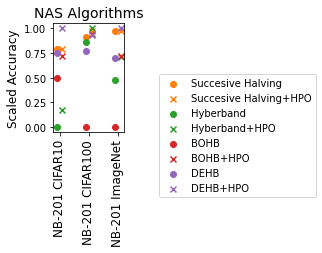

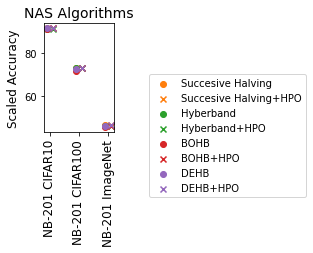

In [16]:
plot_default_hpo(results, search_spaces, optimizers, scale_type='0-1', one_line=True, label=True) #, save='optimizers_appendix.pdf') # scalled 
plot_default_hpo(results, search_spaces, optimizers, scale_type=None, one_line=True, label=True) #, save='optimizers_appendix.pdf') # non scalled




# run the transabilty model

In [18]:
"""
plot a matrix where entry [i,j] is the regret of a predictor 
tuned on search space i and evaluated on search space j.

Some of the matrix code is different types of scaling so that we can see the trends better
"""
def compute_matrix(results, ss_group, optimizers, optimizer):

    # first, compute a list of all seeds that have full info
    hpo_seeds = []
    for hpo_seed in results.keys():
        valid = True
        for search_space in ss_group:
            for pred in optimizers:
                if not (search_space in results[hpo_seed] and \
                        pred in results[hpo_seed][search_space]):
                    valid = False
        if valid:
            hpo_seeds.append(hpo_seed)
        else:
            pass
    print('num valid', len(hpo_seeds))

    # now compute the raw results and best seed for each search space
    best_seeds = []
    raw_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    scaled_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    for i, search_space in enumerate(ss_group):
        raw_seed_results[i] = [results[hpo_seed][search_space][optimizer][0] for hpo_seed in hpo_seeds]
        best_seeds.append(np.argmax(raw_seed_results[i]))
        # 0-1 scaling:
        min_acc, max_acc = np.min(raw_seed_results[i]), np.max(raw_seed_results[i])
        scaled_seed_results[i] = [(m - min_acc) / (max_acc - min_acc) for m in raw_seed_results[i]]

    # compute the matrices
    div_matrix = np.zeros((len(ss_group), len(ss_group)))
    kt_matrix = np.zeros((len(ss_group), len(ss_group)))
    scaled_matrix = np.zeros((len(ss_group), len(ss_group)))

    for i, ss_1 in enumerate(ss_group):
        for j, ss_2 in enumerate(ss_group):
            div_matrix[i][j] = scaled_seed_results[i][best_seeds[j]] / scaled_seed_results[i][best_seeds[i]]
            scaled_matrix[i][j] = scaled_seed_results[i][best_seeds[i]] - scaled_seed_results[i][best_seeds[j]]
            kt_matrix[i][j] = kendalltau(raw_seed_results[i], raw_seed_results[j])[0]

    return div_matrix, scaled_matrix, kt_matrix, scaled_seed_results

def scale_matrix(matrix, mean_div=2.5):
    # further scaling of the results
    # needs to happen in its own method so that an avg_matrix is input
    scaled_matrix = np.zeros((len(matrix), len(matrix)))
    maximum = np.max(matrix)
    mean = np.mean(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if mean_div > 0:
                scaled_matrix[i][j] = np.minimum(matrix[i][j], mean * mean_div)
            else:
                scaled_matrix[i][j] = np.maximum(matrix[i][j], mean / mean_div * -1)

    # 0-1 scale
    min_acc, max_acc = np.min(scaled_matrix), np.max(scaled_matrix)
    for i in range(len(scaled_matrix)):
        for j in range(len(scaled_matrix)):
            scaled_matrix[i][j] = (scaled_matrix[i][j] - min_acc) / (max_acc - min_acc) 

    return scaled_matrix

def plot_matrix(matrix, ss_group, save=None, cmap='viridis', hparam=False, title = "Optimizers"):
    coords = matrix
    cellsize = 5
    fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*coords.shape[0]/coords.shape[1]))
    im = ax.pcolormesh(coords, edgecolor='k', linewidth=0.5, cmap=cmap) 
    if hparam:
        plt.title('HParam. Corr. for {}'.format(title))
    else:
        plt.title('Generalizability for {}'.format(title))
    plt.gca().invert_yaxis()
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xticks([c+0.5 for c in range(coords.shape[0]-0)], minor=True)
    ax.set_xticklabels([ss_dict_oneline[ss] for ss in ss_group], minor=True, rotation=90)
    ax.set_yticks([])
    ax.set_yticklabels('')    
    ax.set_yticks([c+0.5 for c in range(coords.shape[1]-0)], minor=True)
    ax.set_yticklabels([ss_dict_oneline[ss] for ss in ss_group], minor=True)
    fig.colorbar(im, ax=ax)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)
        
    return matrix

num valid 100
num valid 100
num valid 100
num valid 100


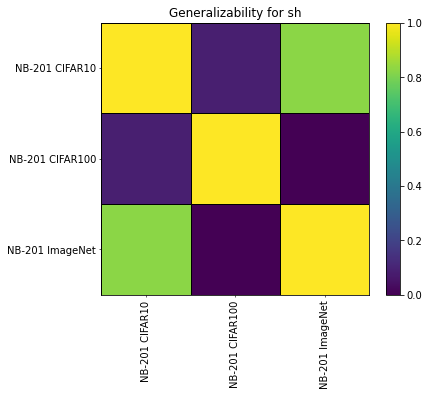

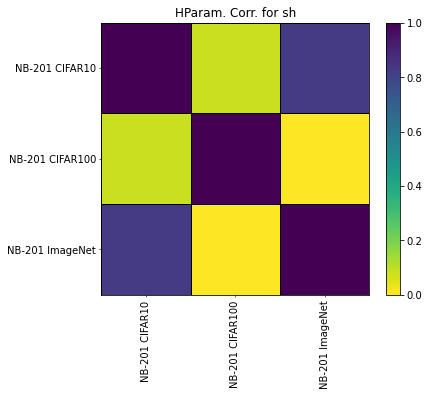

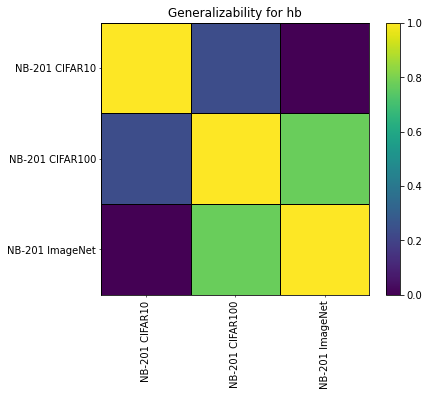

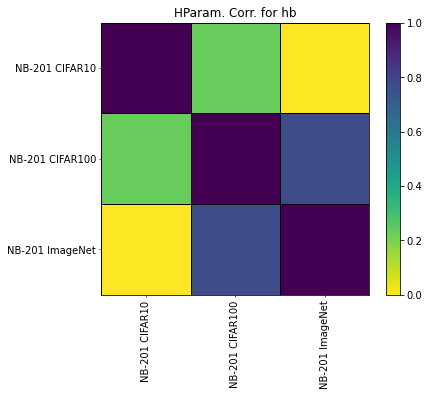

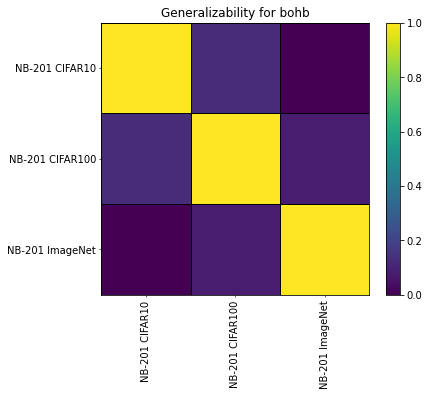

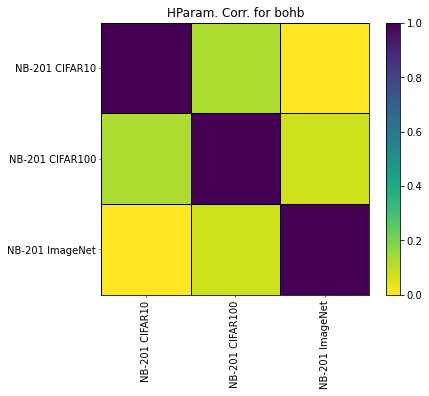

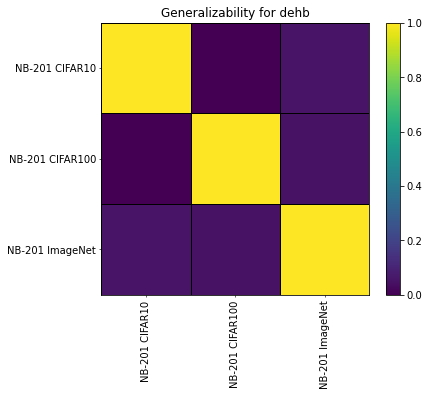

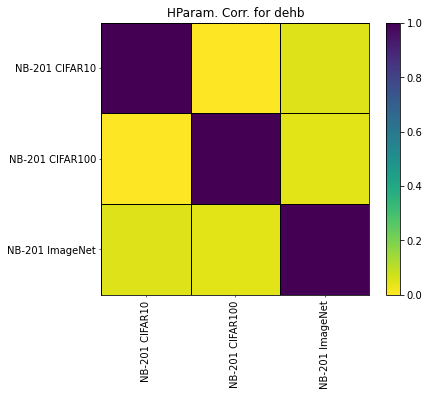

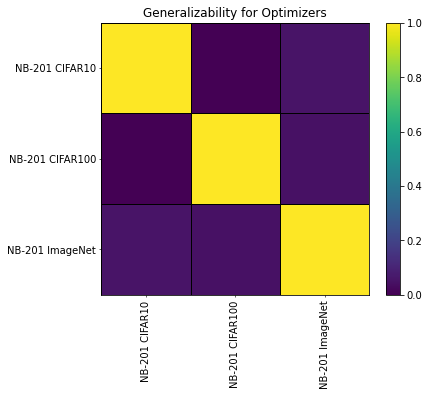

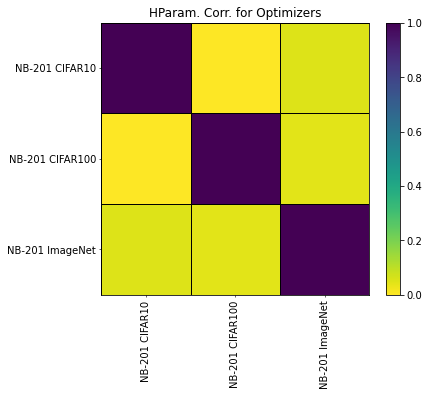

In [19]:
#have to load different results
norm_matrices = []
kt_matrices = []
for i, optimizer in enumerate(optimizers):
    div_mat, scaled_mat, kt_mat, scaled_seed_results = compute_matrix(results, search_spaces, optimizers, optimizer)
    #norm = compute_matrix(results, best_configs[i], optimizer, search_spaces)
    norm_matrices.append(scaled_mat)
    kt_matrices.append(kt_mat)
    scaled_matrix = scale_matrix(kt_mat, mean_div=-2.5)
    scaled_kt_matrix = scale_matrix(kt_mat, mean_div=-100000)
    scaled_matrix = plot_matrix(scaled_matrix, search_spaces, cmap='viridis', title=optimizer) #, save='bbo_matrix_avg.pdf')
    scaled_kt_matrix = plot_matrix(scaled_kt_matrix, search_spaces, cmap='viridis_r',hparam=True,  title=optimizer)

avg_norm_matrix = np.mean(np.array(norm_matrices), axis=0)
avg_kt_matrix = np.mean(np.array(kt_matrices), axis=0)

scaled_avg_matrix = scale_matrix(avg_norm_matrix, mean_div=2.5)
scaled_avg_kt_matrix = scale_matrix(avg_kt_matrix, mean_div=-1000000)

avg_scaled_matrix = plot_matrix(scaled_matrix, search_spaces, cmap='viridis') #, save='bbo_matrix_avg.pdf')
_ = plot_matrix(scaled_kt_matrix, search_spaces, cmap='viridis_r', hparam=True) #, save='bbo_corr_matrix.pdf')

0